In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import lightkurve as lk
from astropy.modeling import models, fitting
from astropy.convolution import convolve, Box1DKernel


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [16]:
stars = ['GJ207.1', 'G203-47', 'LHS_1817', 'Wolf_1130']
tics = ['220044948', '219085795', '71038757', '233342788']
periods_lit = np.array([0.60417356,14.7136,0.30992678, 0.49670418])*u.d


orbital period references  
GJ207.1 https://ui.adsabs.harvard.edu/abs/2021A%26A...653A..49B/abstract  
G203-47 https://ui.adsabs.harvard.edu/abs/1999A%26A...344..897D/abstract  
LHS_1817 https://ui.adsabs.harvard.edu/abs/2020AJ....159..290W/abstract  
Wolf 1130 https://ui.adsabs.harvard.edu/abs/2018ApJ...854..145M/abstract  


In [3]:
for tic in tics:
    search_result = lk.search_lightcurve('TIC {}'.format(tic))
    print(search_result)

SearchResult containing 12 data products.

 #     mission     year       author      exptime target_name distance
                                             s                 arcsec 
--- -------------- ---- ----------------- ------- ----------- --------
  0 TESS Sector 06 2018              SPOC     120   220044948      0.0
  1 TESS Sector 32 2020              SPOC      20   220044948      0.0
  2 TESS Sector 32 2020              SPOC     120   220044948      0.0
  3 TESS Sector 06 2018         TESS-SPOC    1800   220044948      0.0
  4 TESS Sector 32 2020         TESS-SPOC     600   220044948      0.0
  5 TESS Sector 06 2018               QLP    1800   220044948      0.0
  6 TESS Sector 32 2020               QLP     600   220044948      0.0
  7 TESS Sector 06 2018             TASOC     120   220044948      0.0
  8 TESS Sector 06 2018 GSFC-ELEANOR-LITE    1800   220044948      0.0
  9 TESS Sector 06 2018             TASOC    1800   220044948      0.0
 10 TESS Sector 06 2018           

GJ207.1 220044948


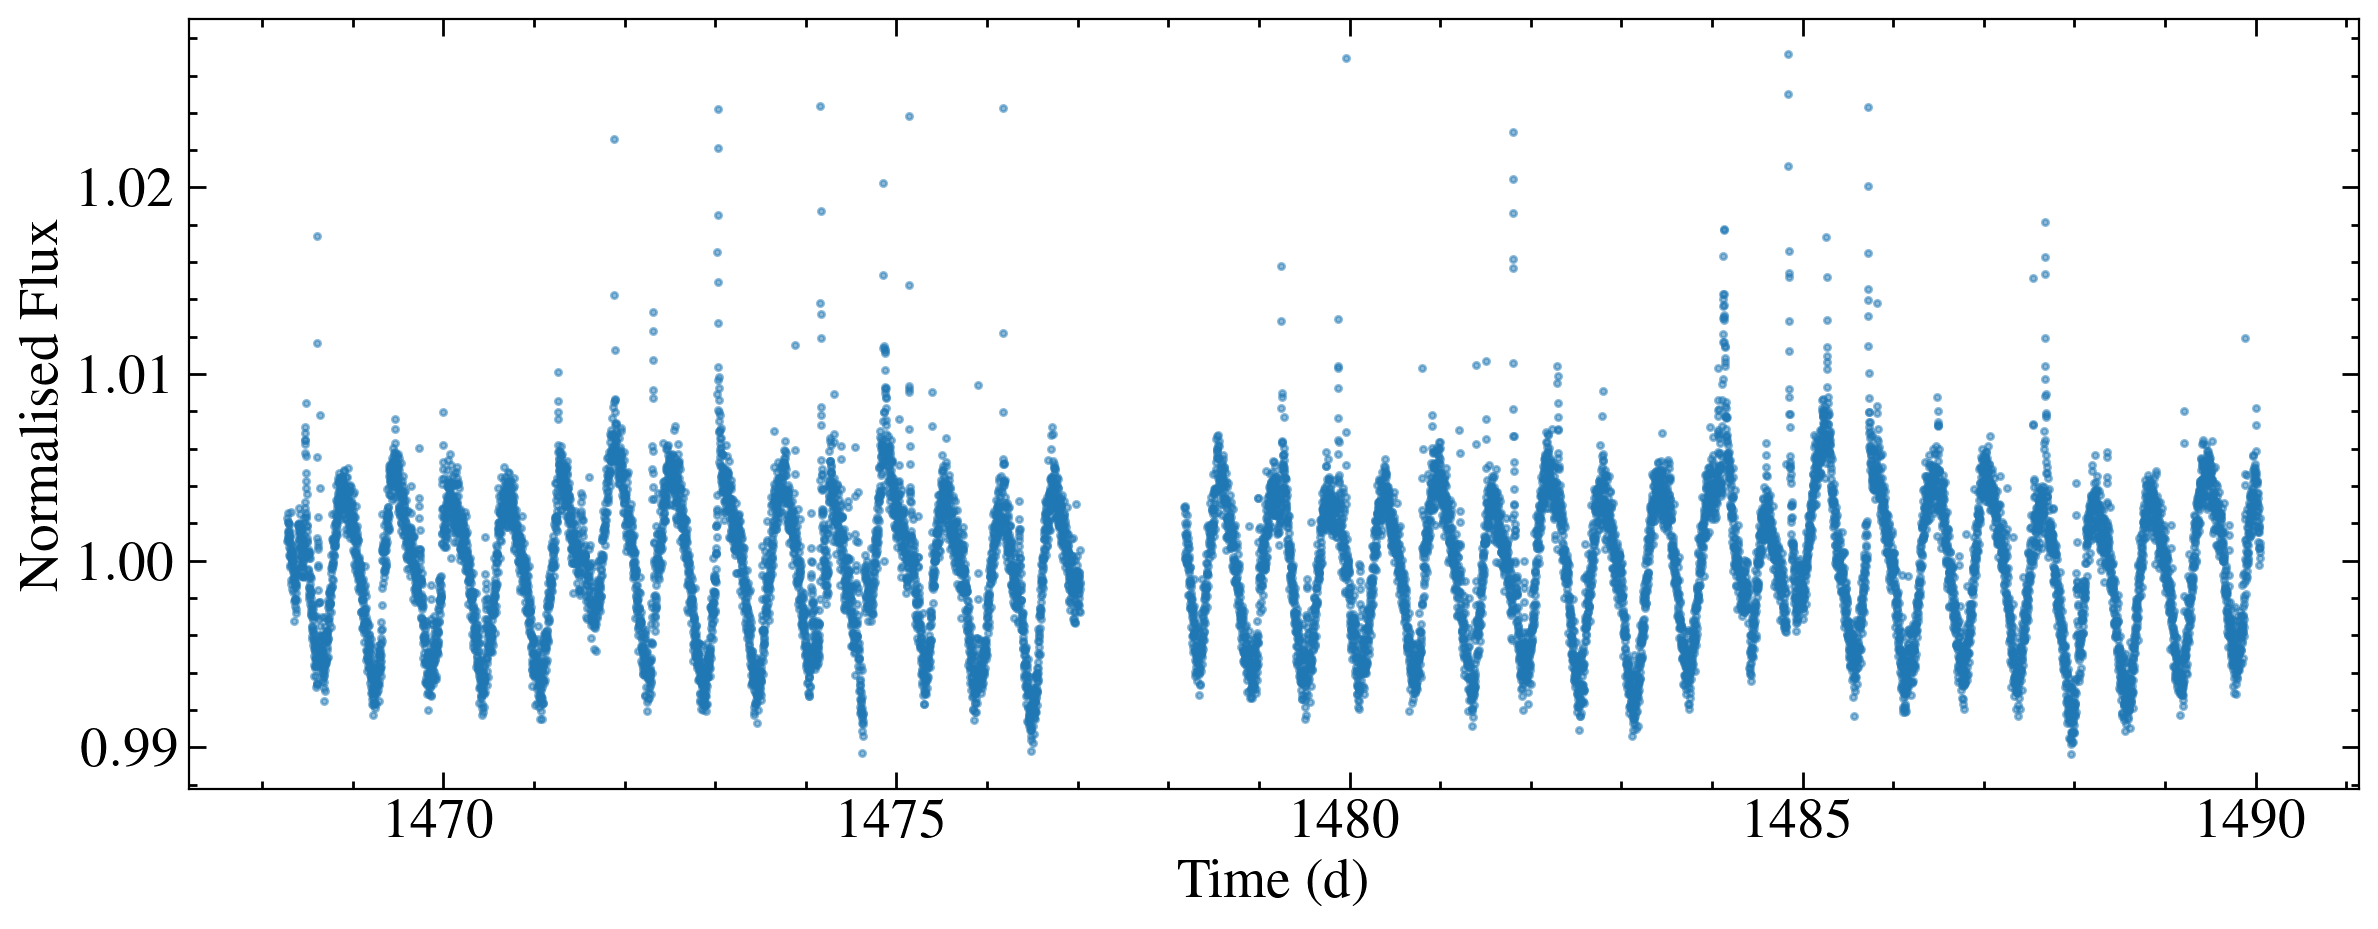

ls peak 0.6040947982657292 d 14.498275158377501 h known period 0.60417356 d 14.50016544 h ratio 0.9998696372375666


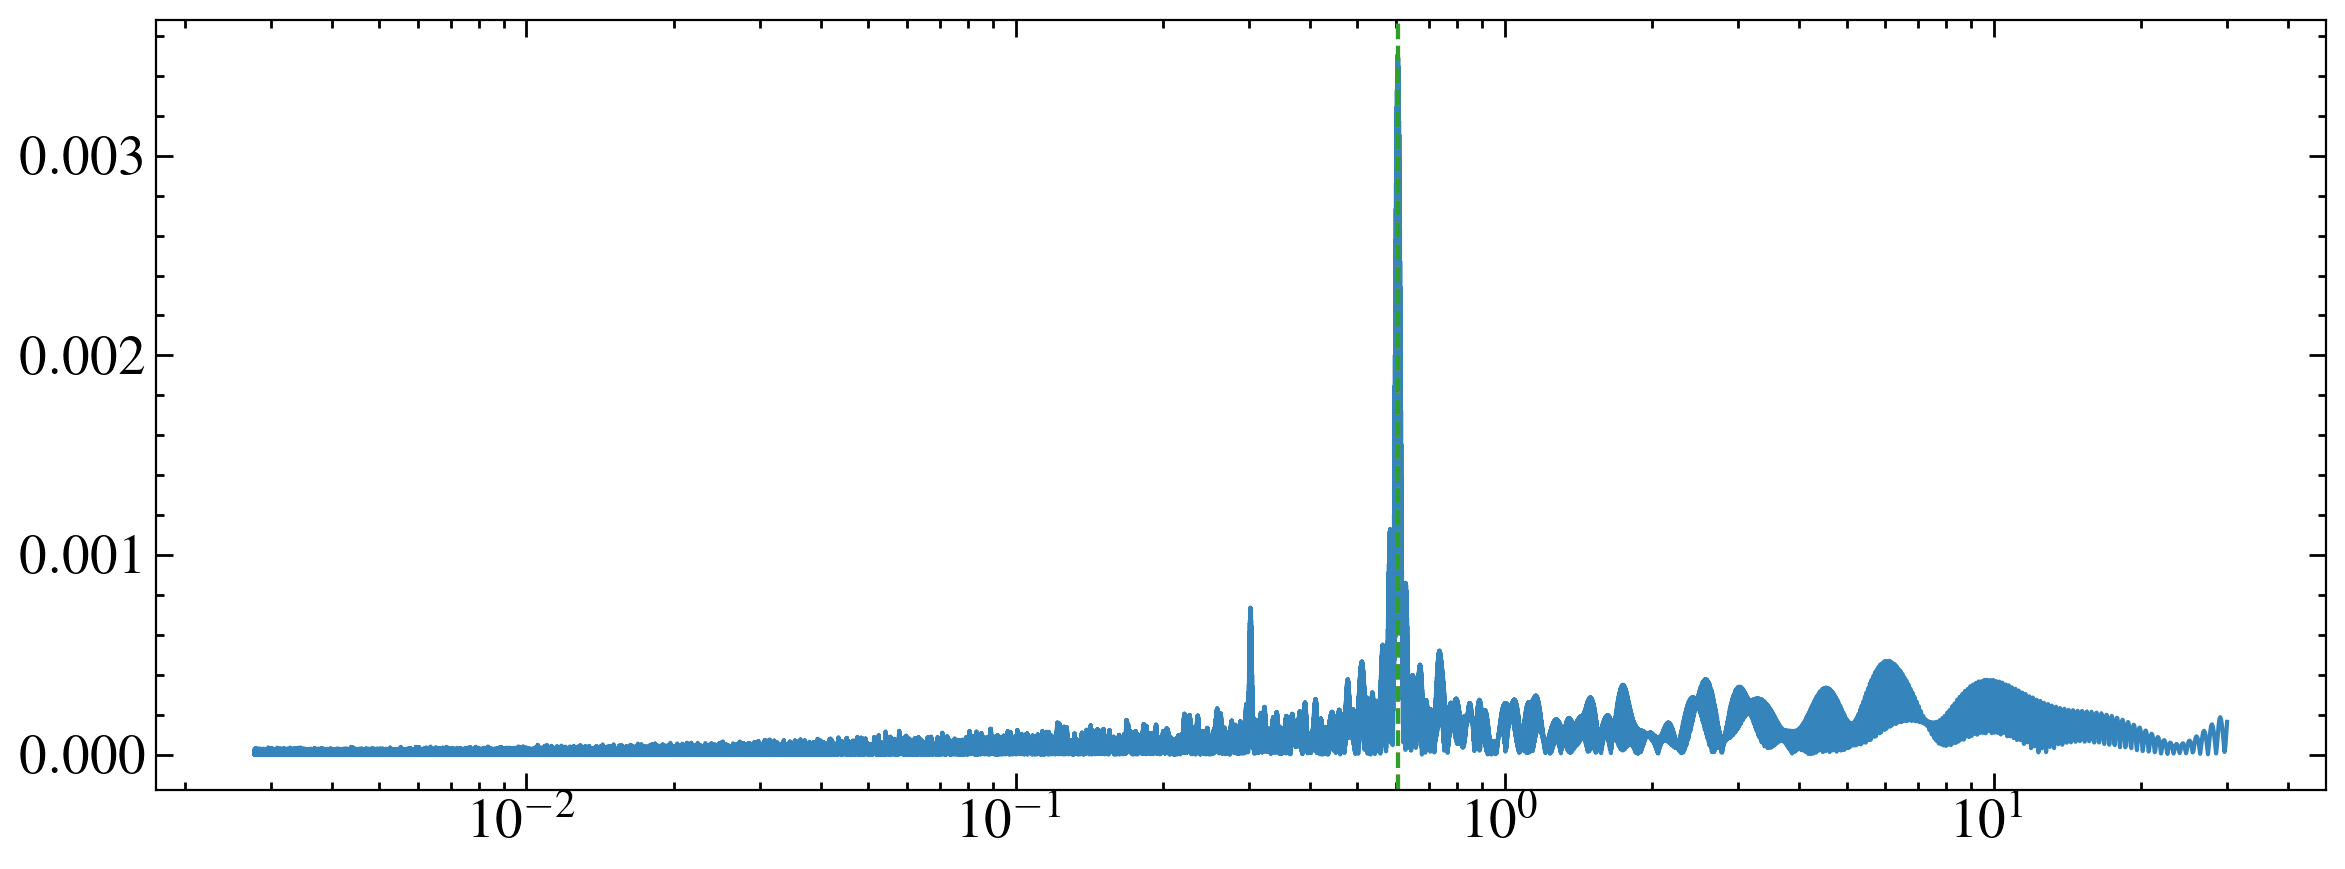

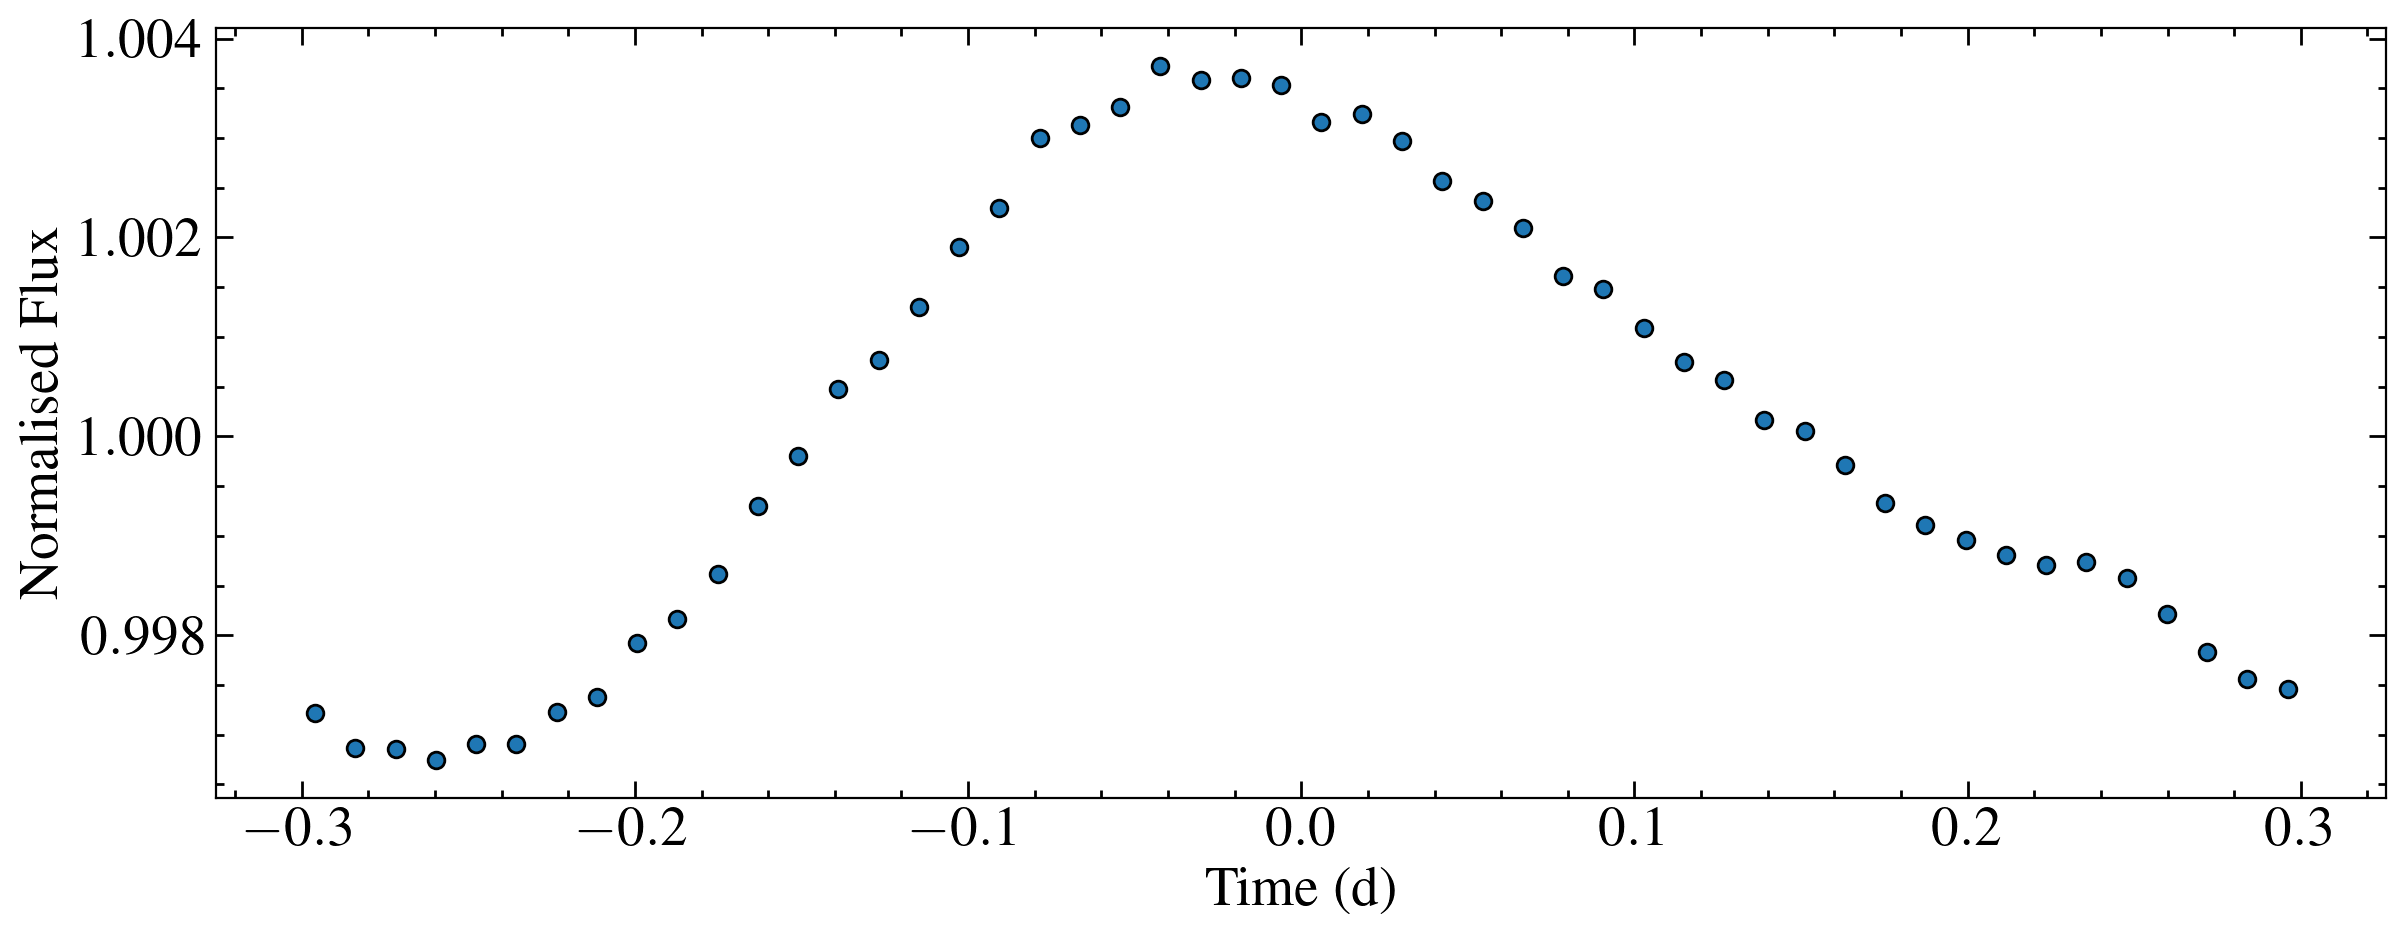

G203-47 219085795


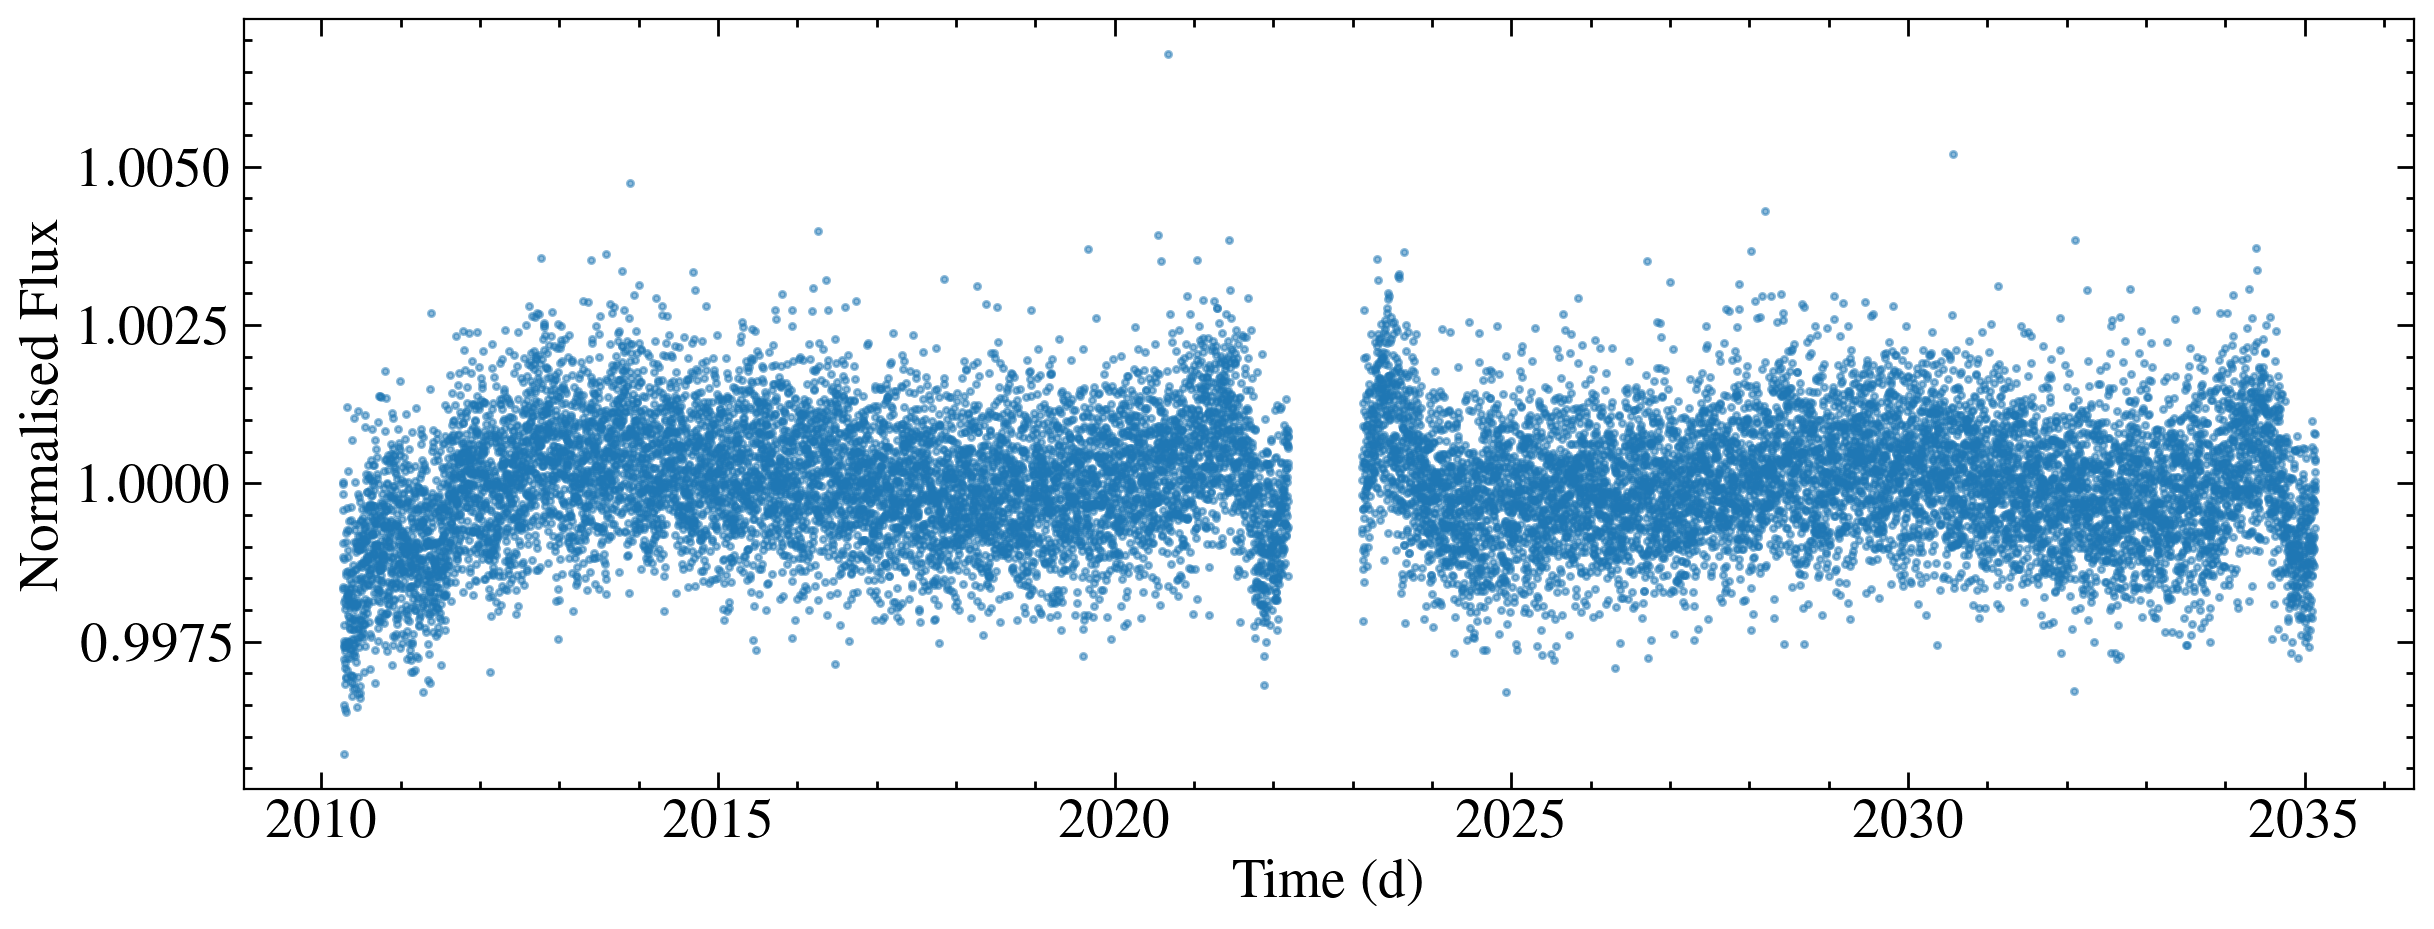

ls peak 4.90979958939638 d 117.83519014551312 h known period 14.7136 d 353.1264 h ratio 0.333691250910476


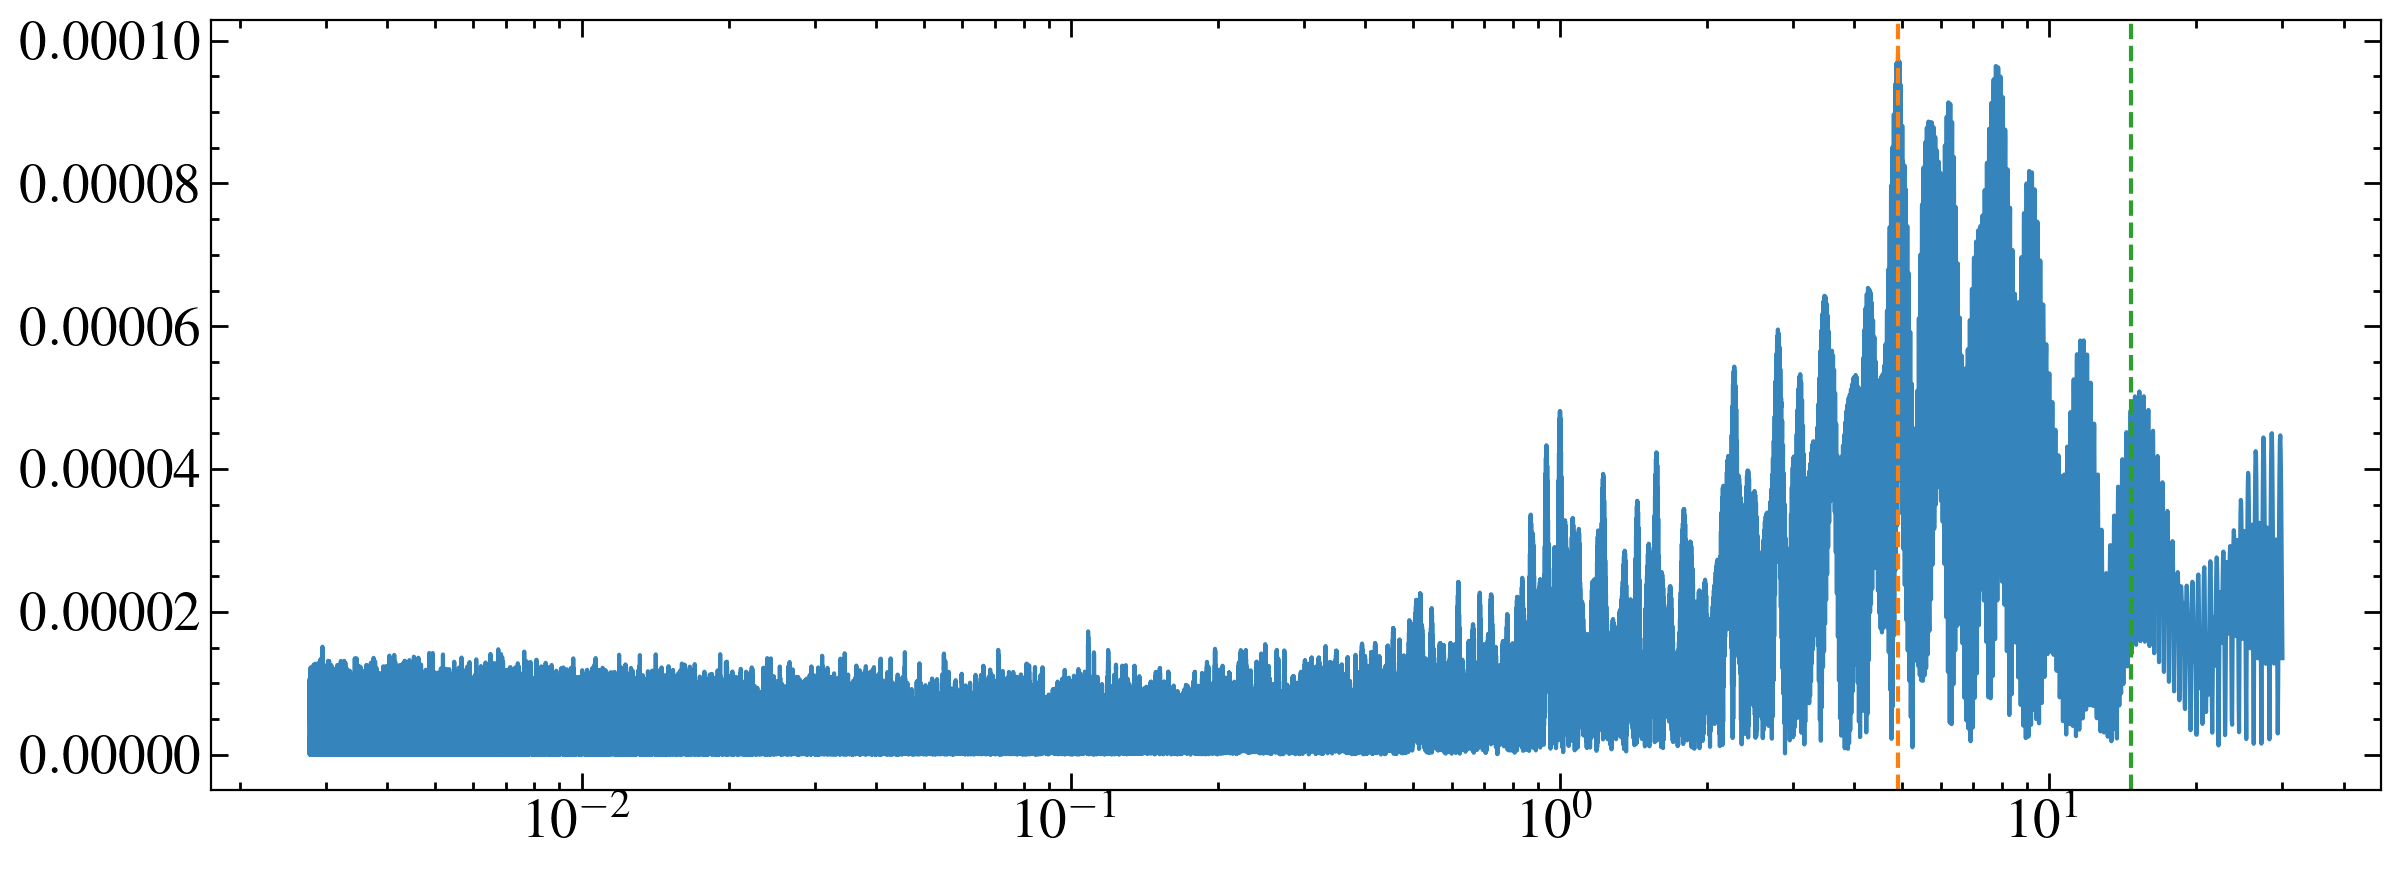

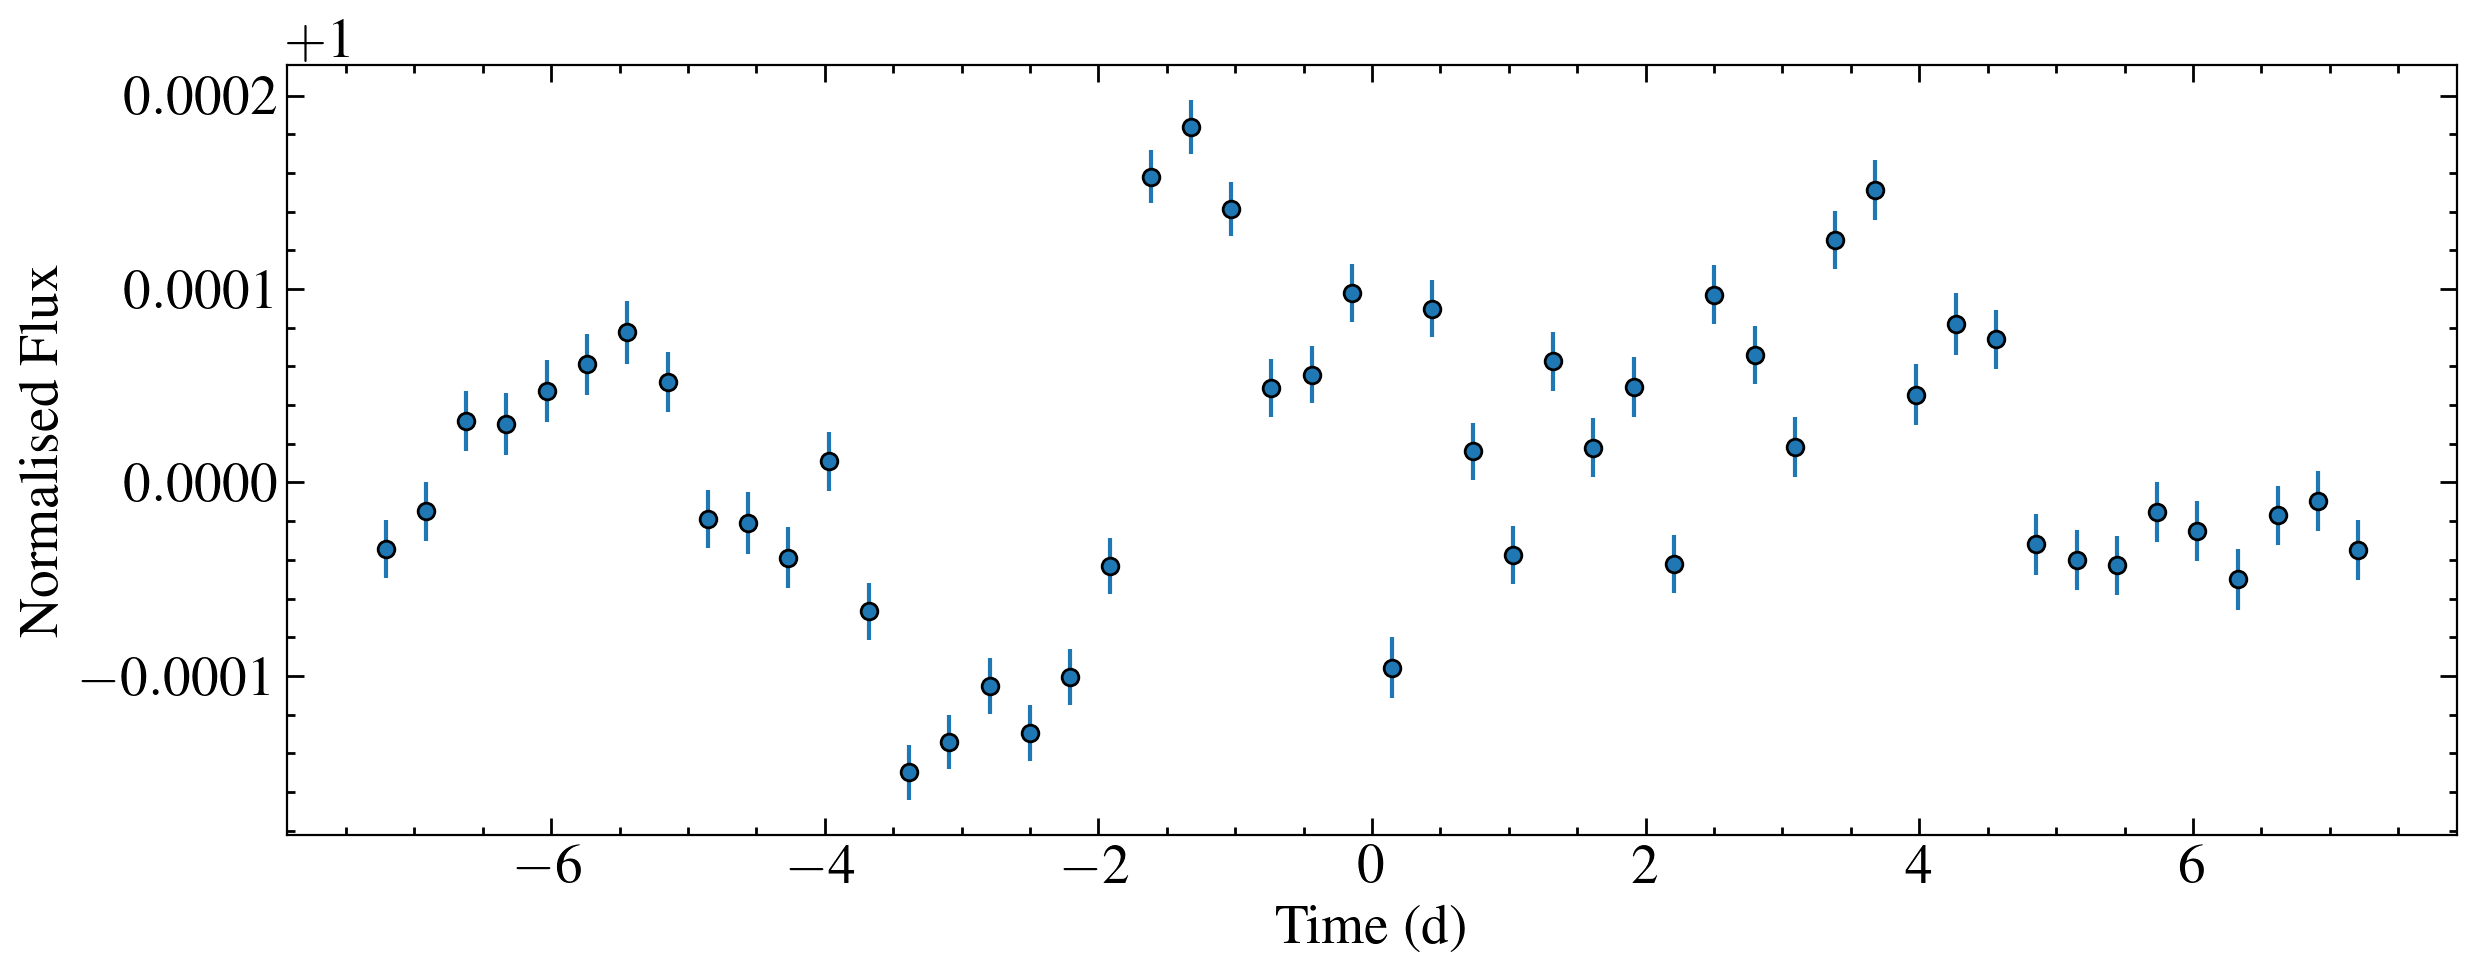

LHS_1817 71038757


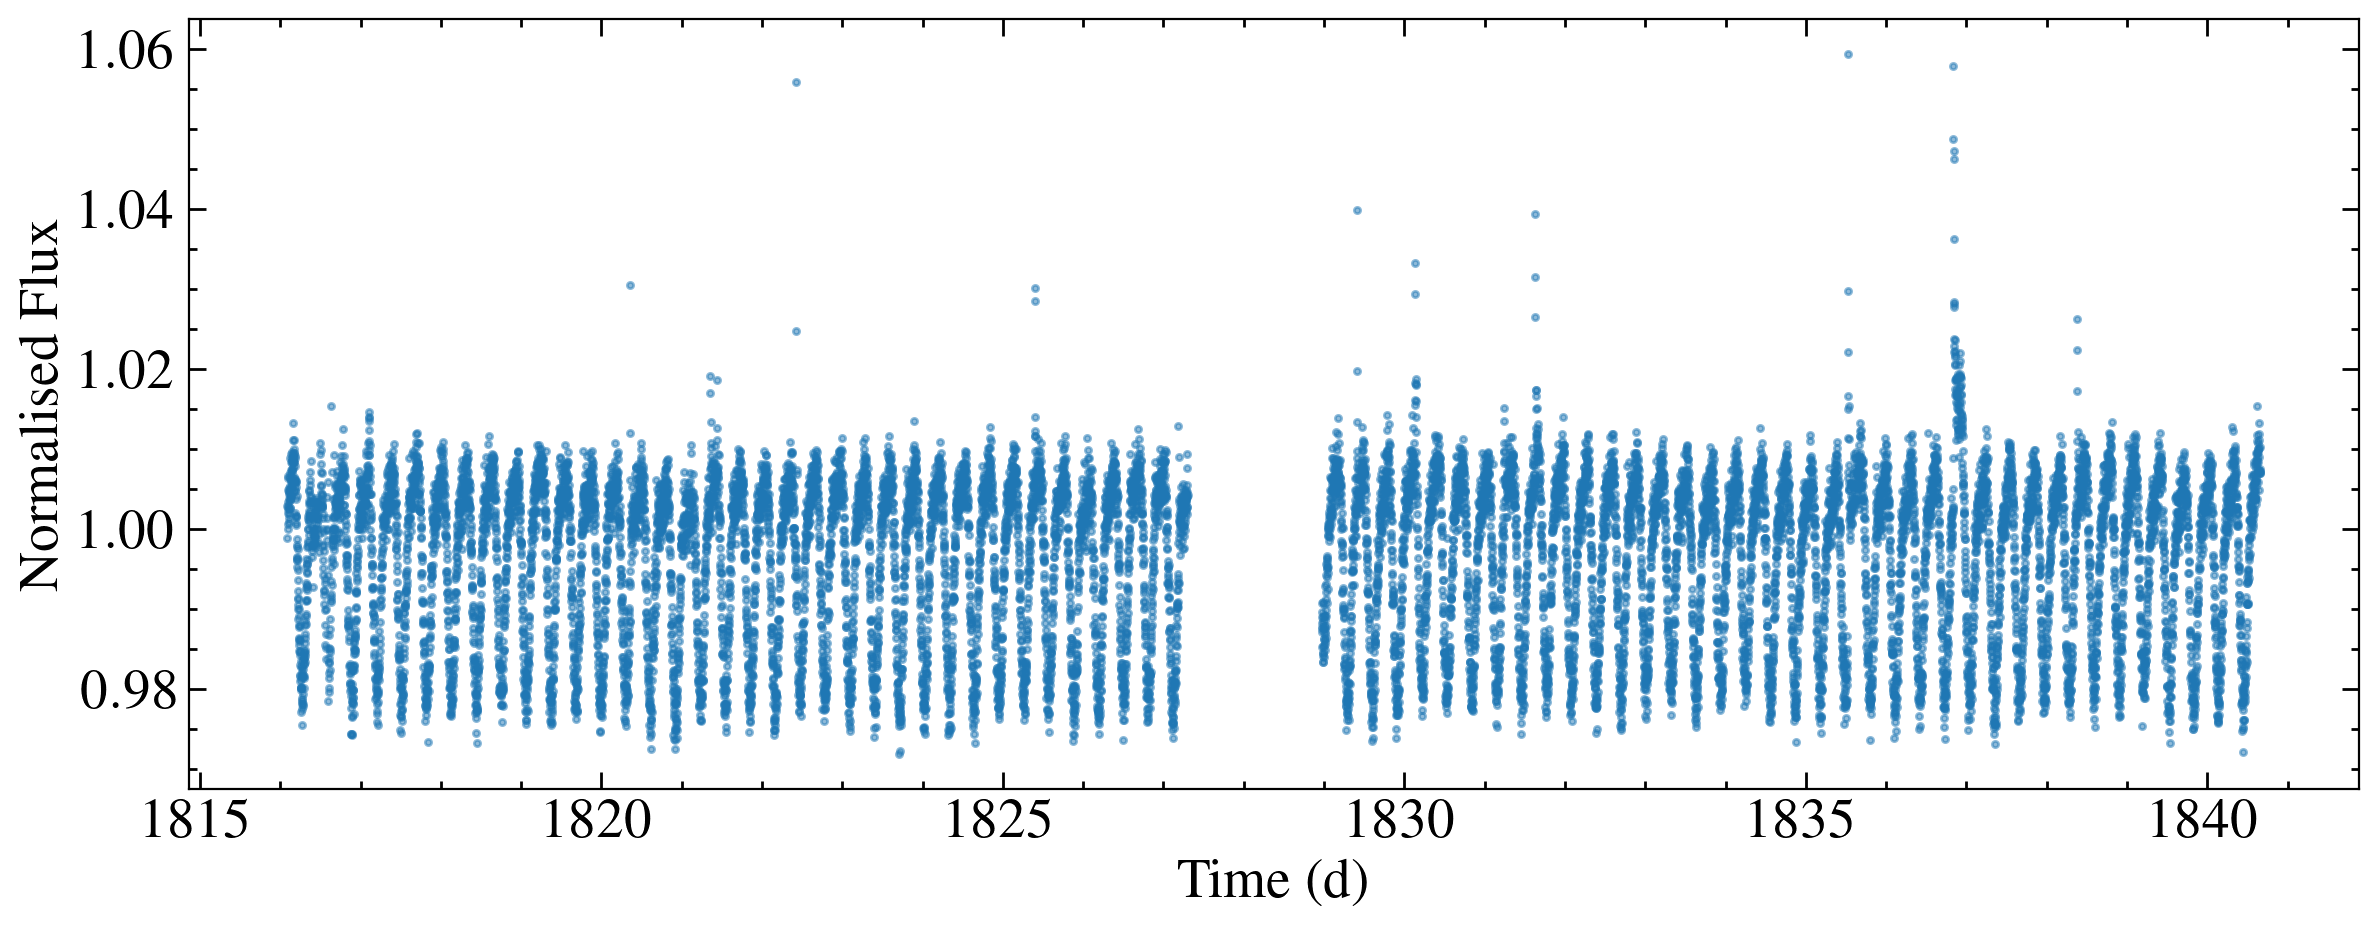

ls peak 0.30995508286313606 d 7.438921988715265 h known period 0.30992678 d 7.43824272 h ratio 1.0000913211279647


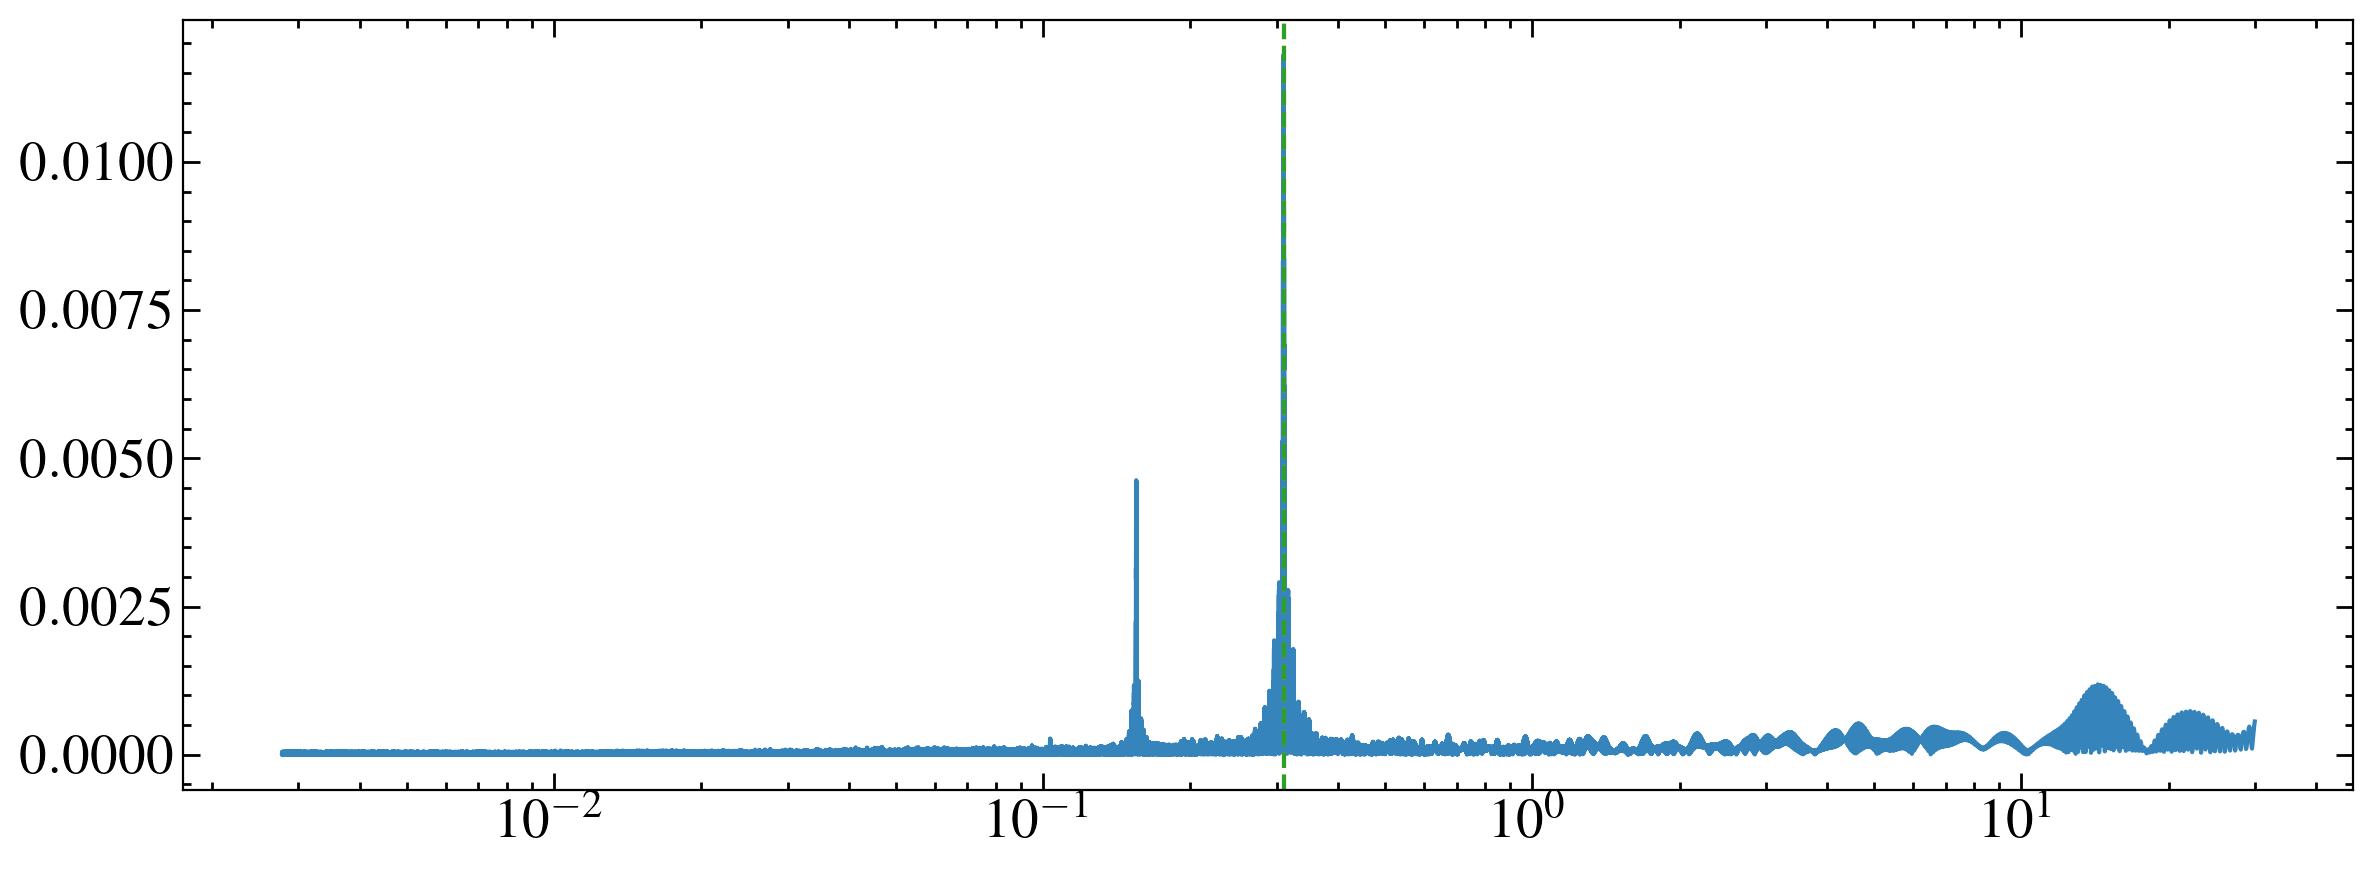

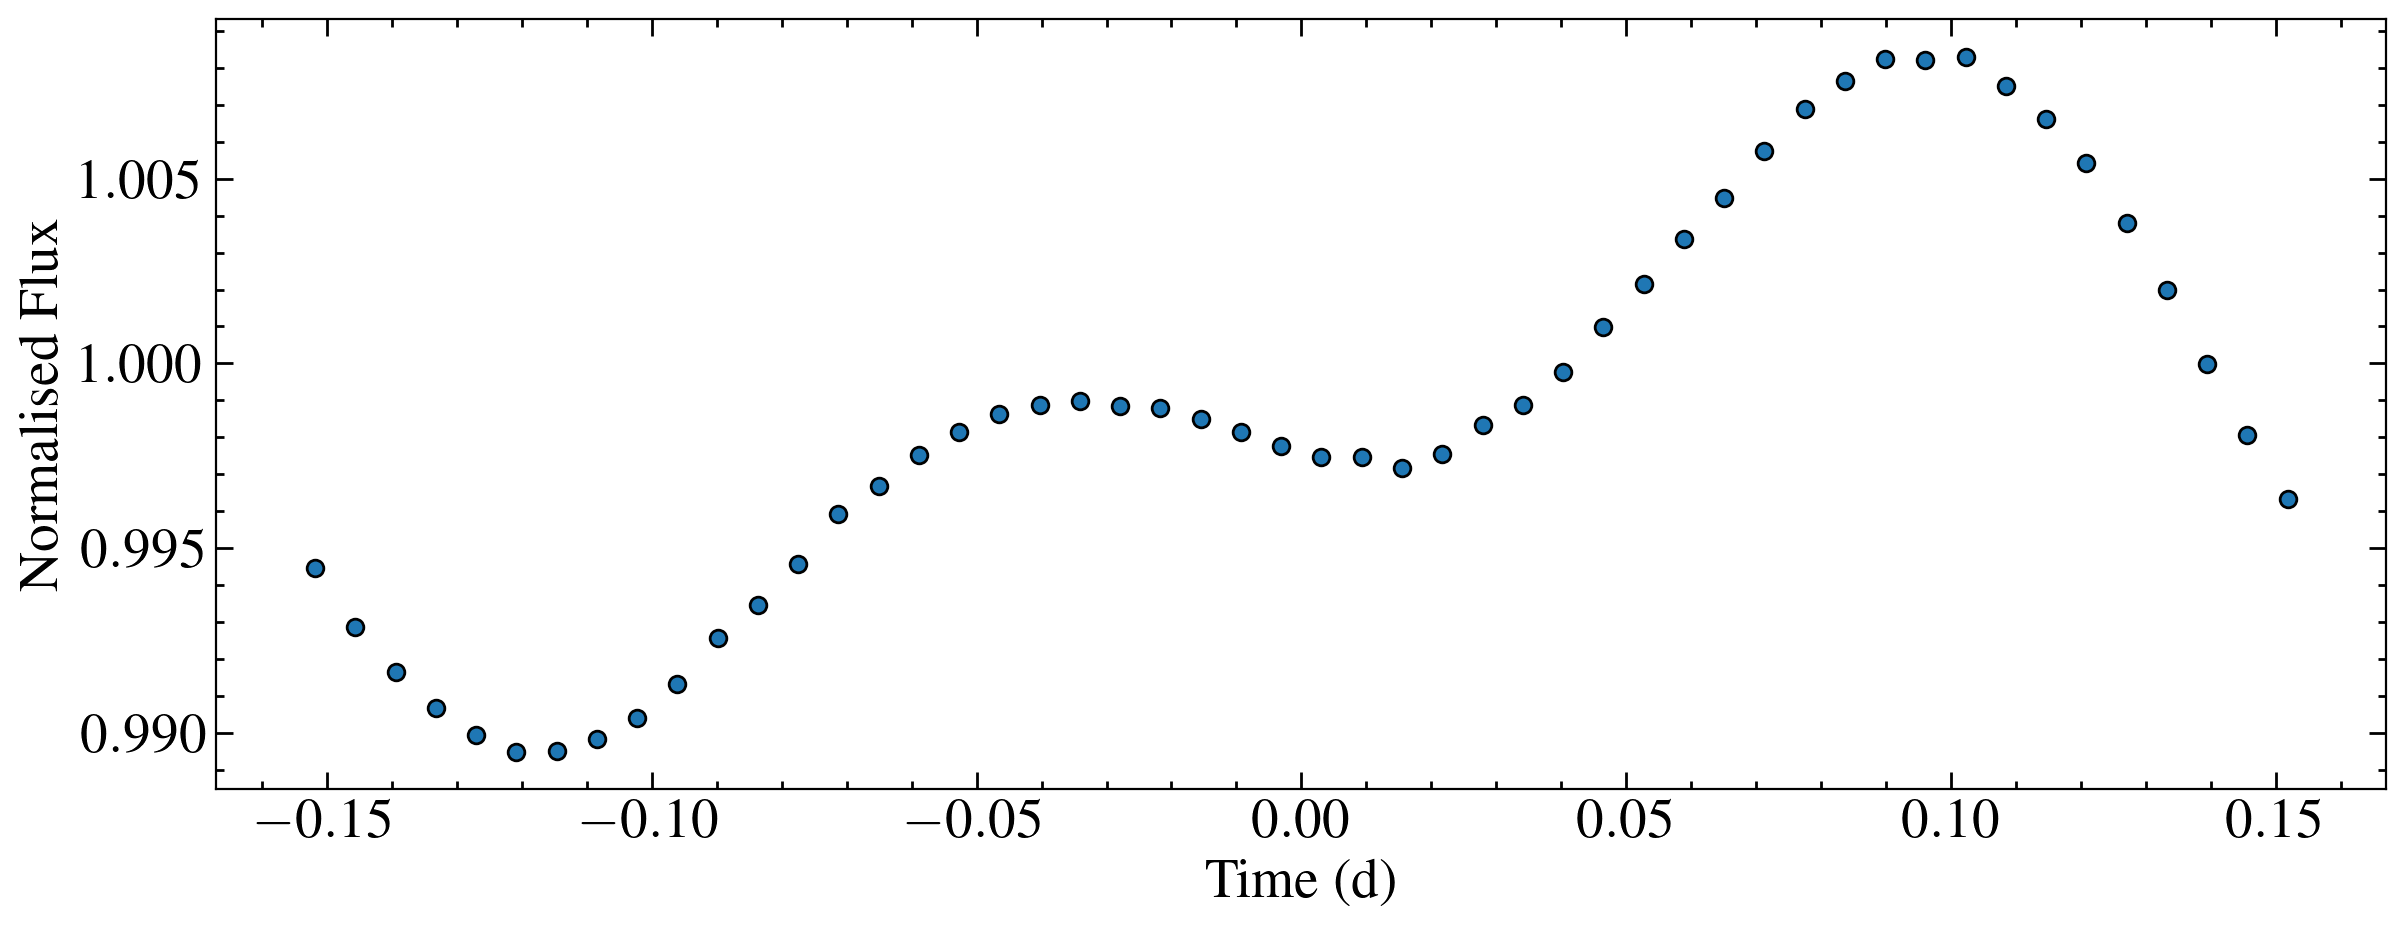

Wolf_1130 233342788


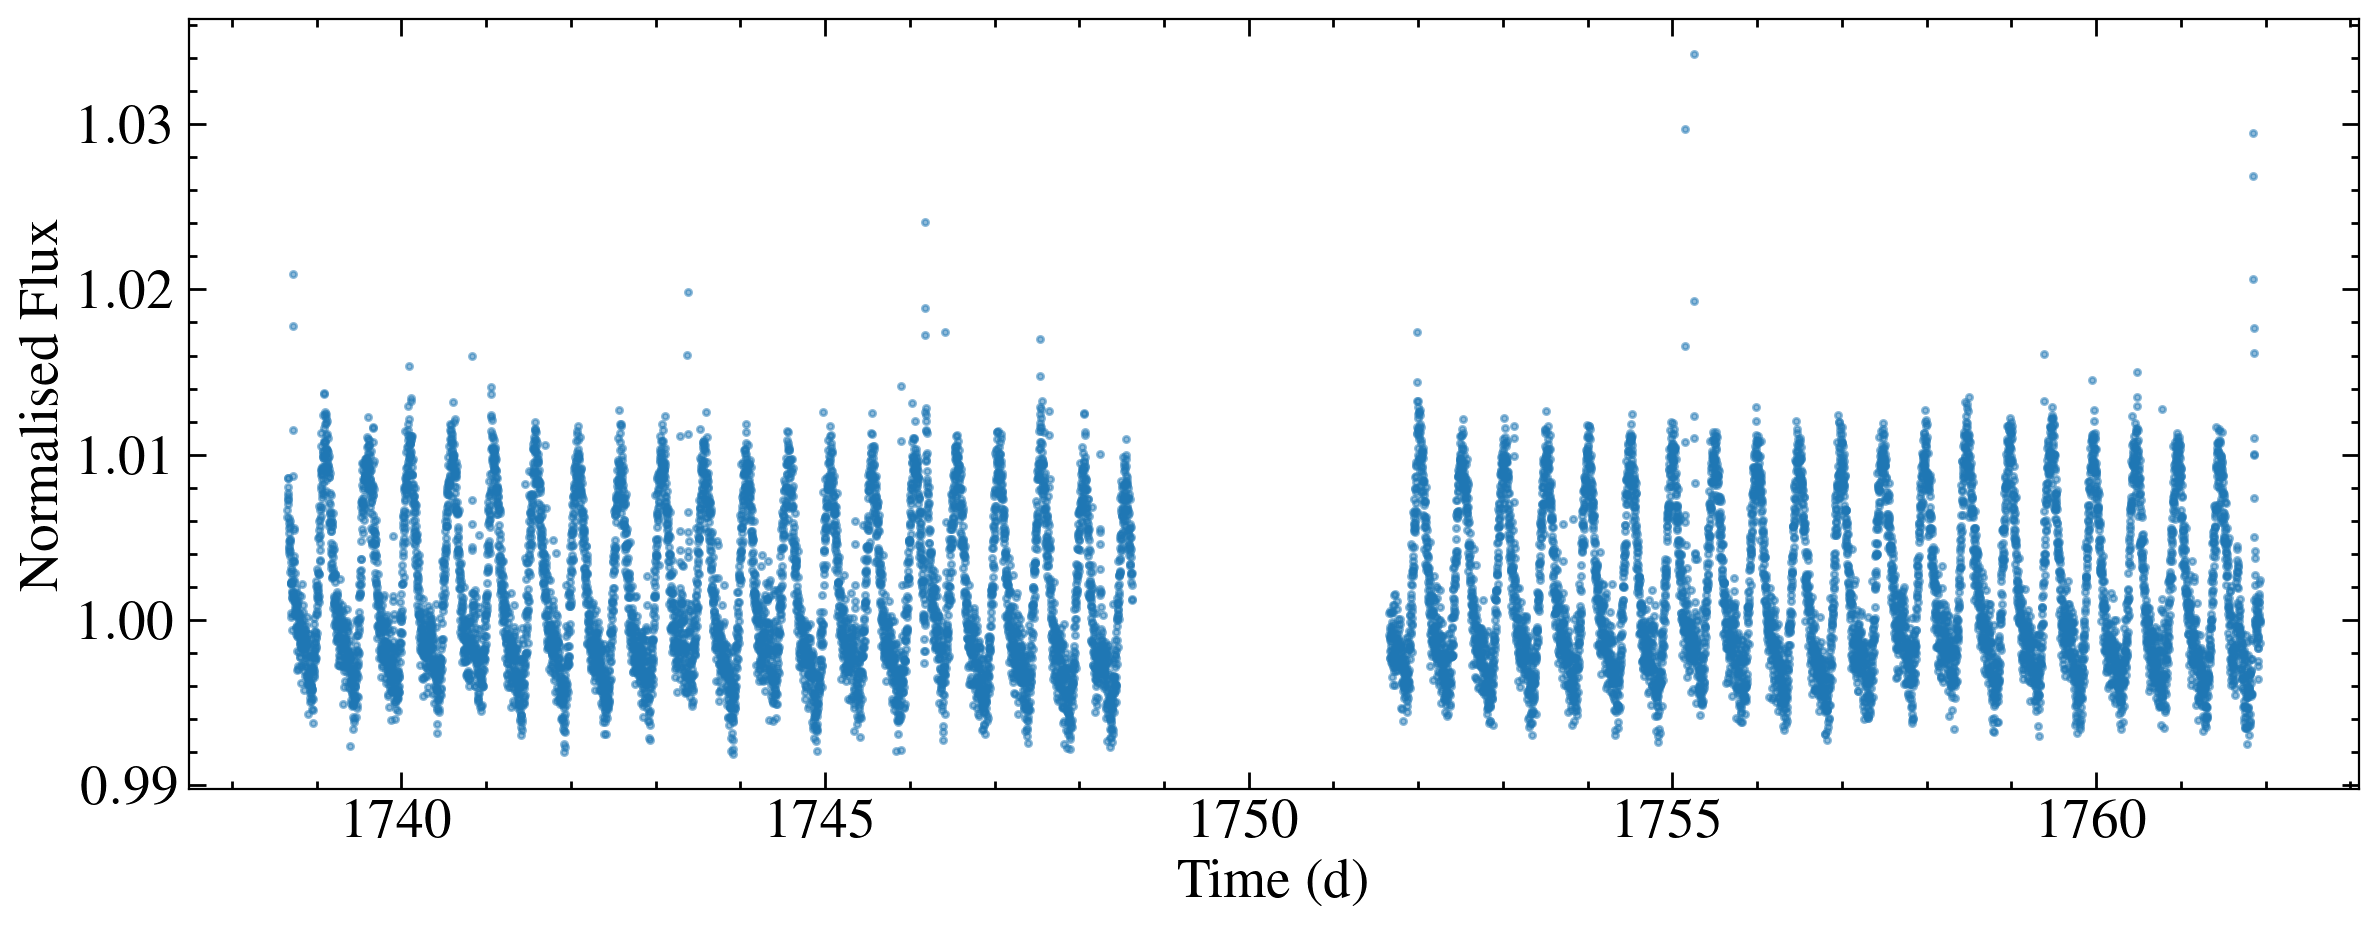

ls peak 0.4966927104710586 d 11.920625051305407 h known period 0.49670418 d 11.92090032 h ratio 0.9999769087327967


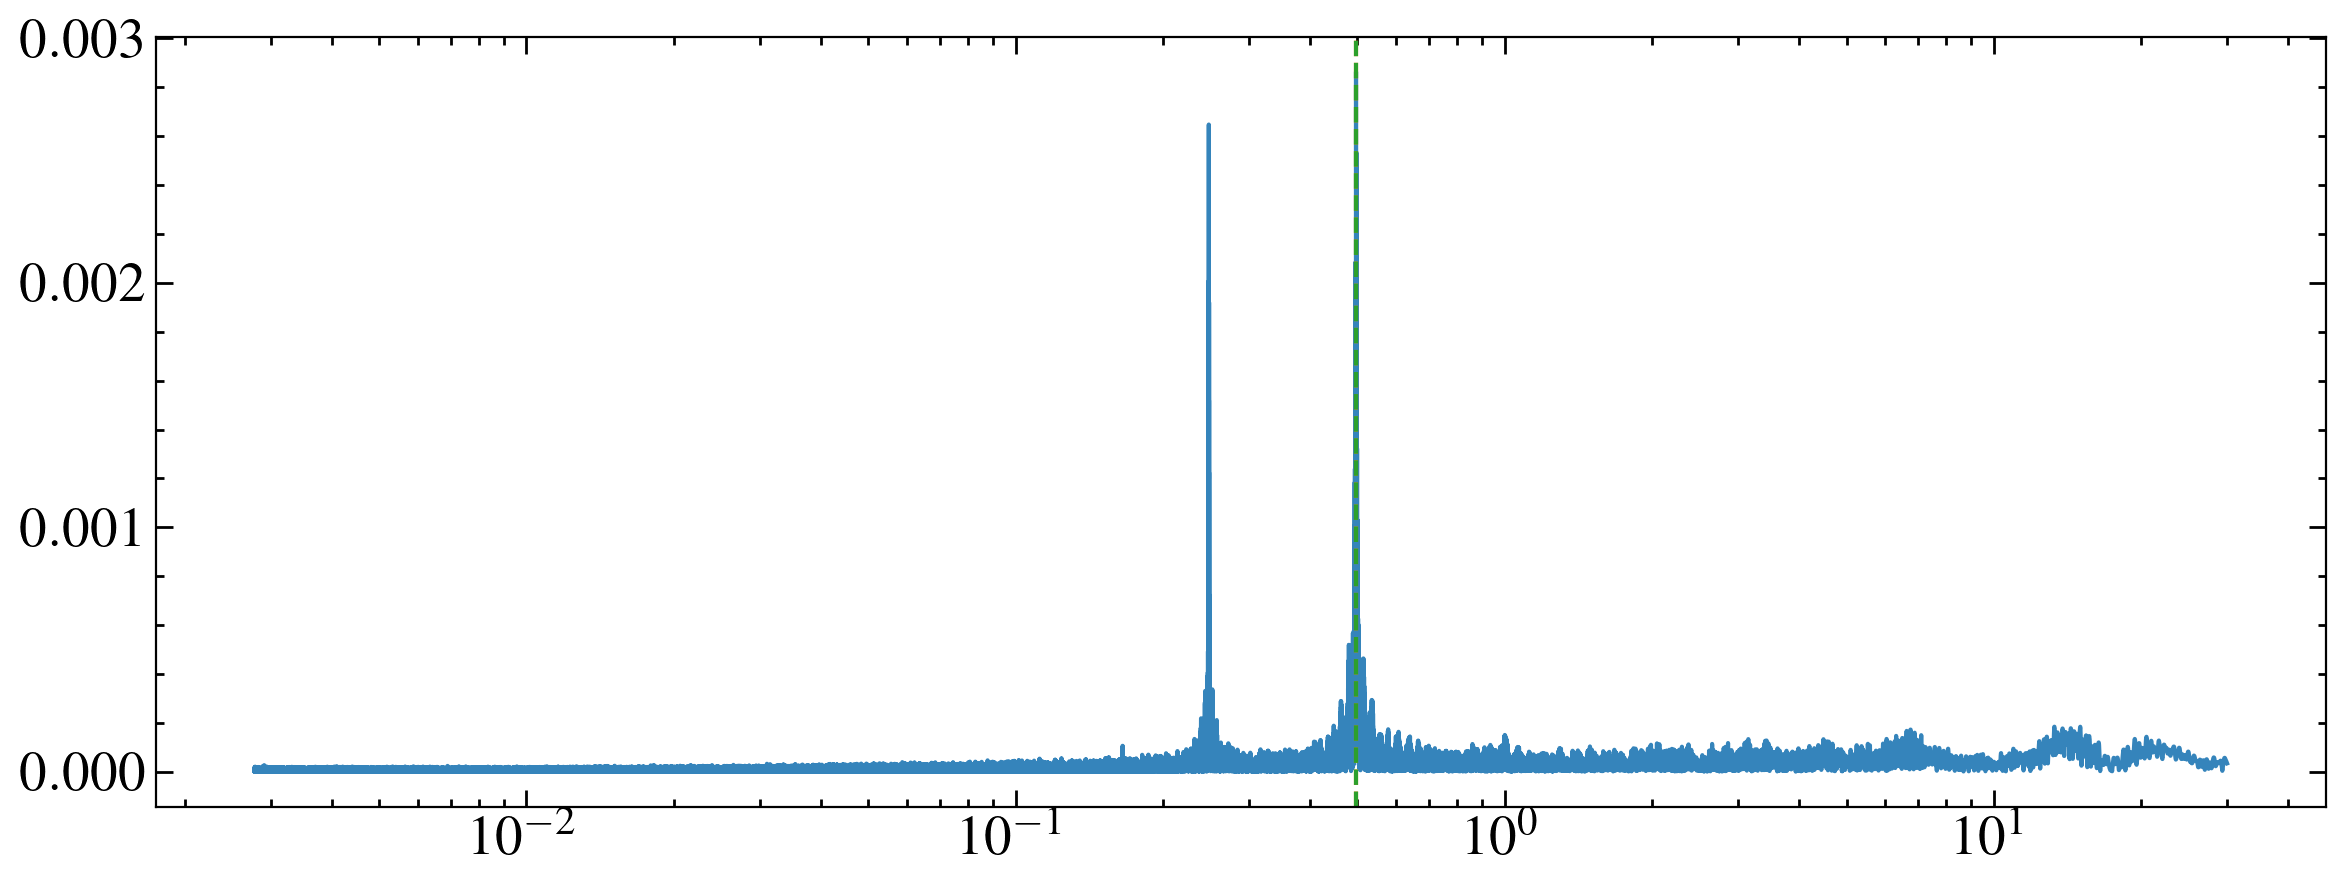

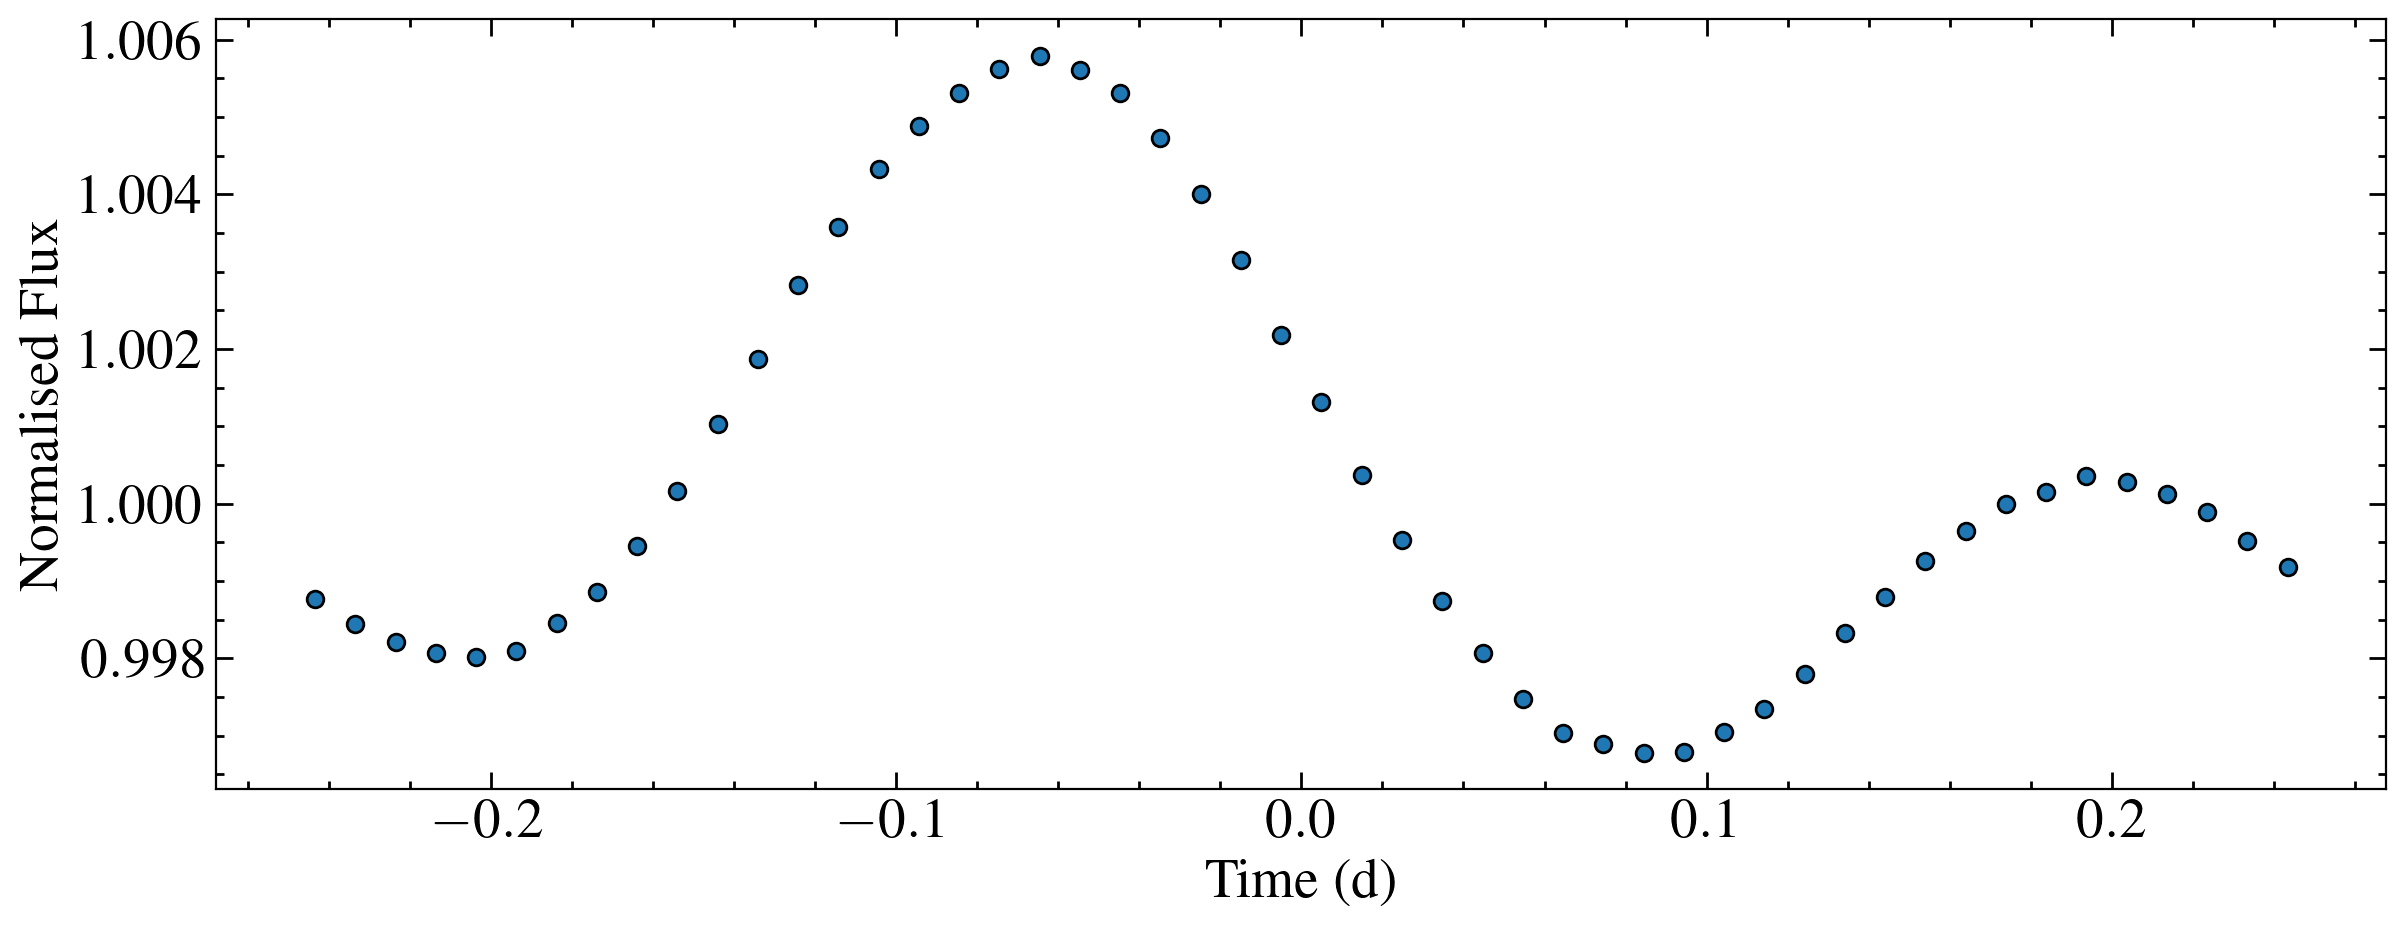

In [63]:
cols = ['C0', 'C1', 'C2']


for i, tic in enumerate(tics):
    print(stars[i], tic)
    search_result = lk.search_lightcurve('TIC {}'.format(tic))
    # print(search_result)
    mask = (search_result.exptime == 120*u.s) & (search_result.author == 'SPOC')
    lcs120 = search_result[mask]
    fig, ax = plt.subplots()
    
    for j, sr in enumerate(lcs120):
        lc = sr.download(download_dir='mastDownload/')
        lc = lc.remove_outliers(sigma=7).flatten(window_length=10001)
        if j == 0:
            lcn = lc
            ax.scatter(lcn.time.value, lcn.flux, alpha=0.5,  s=5, rasterized = True , color=cols[0])
            
        else:
            lcn = lcn.append(lc)
    # ax.scatter(lcn.time.value, lcn.flux, alpha=0.1,  s=5, rasterized = True , color=cols[0])
    ax.set_xlabel('Time (d)')
    ax.set_ylabel('Normalised Flux')
    plt.show()
    
    pg = lcn.to_periodogram(method='ls',oversample_factor=10, minimum_period=4*u.min, maximum_period = 30*u.d)
    period_guess = pg.period_at_max_power
    # print('ls peak', period_guess, period_guess.to(u.hr))
    print('ls peak', period_guess, period_guess.to(u.hr), 'known period', periods_lit[i],periods_lit[i].to(u.hr), 'ratio', period_guess/periods_lit[i] )
    
    fig, ax = plt.subplots()
    ax.plot(pg.period, pg.power, alpha=0.9, color=cols[0])
    ax.axvline(period_guess.value, ls='--', c=cols[1])
    ax.axvline(periods_lit[i].value, ls='--', c=cols[2])
    ax.set_xscale('log')
    plt.show()

    fig, ax = plt.subplots()
    lcf = lcn.fold(periods_lit[i]).bin(periods_lit[i]/50)
    ax.errorbar(lcf.time.value, lcf.flux, yerr=lcf.flux_err, marker='o', ls='none', markeredgecolor='k')
    ax.set_xlabel('Time (d)')
    ax.set_ylabel('Normalised Flux')
    plt.show()



        # lc.plot()
    
# lcs120
    

Is G203-47 ecclipsing?

In [61]:
# cols = ['C0', 'C1', 'C2']


# for i, tic in enumerate(tics):
#     if i == 1:
#         print(stars[i], tic)
#         search_result = lk.search_lightcurve('TIC {}'.format(tic))
#         # print(search_result)
#         mask = (search_result.exptime == 120*u.s) & (search_result.author == 'SPOC')
#         lcs120 = search_result[mask]
#         fig, ax = plt.subplots()
#         for j, sr in enumerate(lcs120):
#             lc = sr.download(download_dir='mastDownload/')
#             lc = lc.remove_outliers(sigma=7).flatten(window_length=5001)
#             # lc = lc.normalize()
#             # lc.plot();
#             if j == 0:
#                 lcn = lc
#                 ax.scatter(lcn.time.value, lcn.flux, alpha=0.5,  s=5, rasterized = True , color=cols[0])
                
#             else:
#                 lcn = lcn.append(lc)
#         # ax.scatter(lcn.time.value, lcn.flux, alpha=0.1,  s=5, rasterized = True , color=cols[0])
#         ax.set_xlabel('Time (d)')
#         ax.set_ylabel('Normalised Flux')
#         plt.show()
        
#         pg = lcn.to_periodogram(method='ls',oversample_factor=10, minimum_period=4*u.min, maximum_period = 30*u.d)
#         # pg = lcn.to_periodogram(method='bls',  minimum_period=10, maximum_period = 30, frequency_factor=10)
#         period_guess = pg.period_at_max_power
#         print('ls peak', period_guess, period_guess.to(u.hr), 'known period', periods_lit[i],periods_lit[i].to(u.hr), 'ratio', period_guess/periods_lit[i] )
#         fig, ax = plt.subplots()
#         ax.plot(pg.period, pg.power, alpha=0.9, color=cols[0])
#         ax.axvline(period_guess.value, ls='--', c=cols[1])
#         ax.axvline(periods_lit[i].value, ls='--', c=cols[2])
#         ax.set_xscale('log')
#         plt.show()
    
#         fig, ax = plt.subplots()
#         lcf = lcn.fold(periods_lit[i]).bin(180*u.min)
#         ax.errorbar(lcf.time.value, lcf.flux, yerr=lcf.flux_err, marker='o', ls='none', markeredgecolor='k')
#         plt.show()
    
    
    
#             # lc.plot()
        
# # lcs120
    

Probably not, could do a full ZTF analysis though.

Don't think there's anything else to get from TESS that isn't beyond scope.